In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import matplotlib.colors as mcolors
import networkx as nx
import pickle

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

dir = "images_1n_wc_w1"

In [3]:
data = dict()
p_names = ["A", "B", "C", "D"]
coords = [[1., 1., "A"], [1.7, 2., "B"], [3., 1., "C"], [4., 2., "D"]]
w1_array = np.array([0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001, 0.0002, 0.0003, 0.00032])
for i in range(len(p_names)):
    p = p_names[i]
    data[p] = dict()
    data[p]["coordinates"] = coords[i]
    data[p]["target_period"] = 15.
    data[p]["control"] = [None for x in range(len(w1_array))]
    data[p]["state"] = [None for x in range(len(w1_array))]
    data[p]["w1"] = w1_array
    if i == 3:
        data[p]["w1"] = w1_array * 0.1

N = 1
model = WCModel()
dt = model.params['dt']
model.params['duration'] = 1. * 1000 # Simulation time, ms

In [35]:
controlmat = np.zeros((N,2))
controlmat[:,0] = 1.

costmat = np.zeros((N, 2))
costmat[:,0] = 1.

duration = 100.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

it = 10000
maxstr = 10

pr = np.arange(0,50001,100)
init_control = zero_control.copy()

In [41]:
for i in range(len(p_names)):

    p = data[p_names[i]]["coordinates"]

    print("pind = ", i, p_names[i], p)
    
    testd = 1000.
    model.params.duration = testd
    test_input = ZeroInput().generate_input(duration=testd+model.params.dt, dt=model.params.dt)
    test_input[0,:1000] = 5.
    model.params["exc_ext"] = test_input + p[0]
    model.params["inh_ext"] = p[1]
    model.run()

    einit = np.zeros((N, 1))
    iinit = np.zeros((N, 1))
    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    model.params.duration = duration
    model.params["exc_ext"] = zero_control[:,0,:] + p[0]
    model.params["inh_ext"] = zero_control[:,1,:] + p[1]
    model.params["exc_init"] = einit
    model.params["inh_init"] = iinit

    model.run()

    target_period = data[p_names[i]]["target_period"]
    i00 = 0
    int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)     
    while int0 > 2*target_period/dt:
        i00 += 1
        int0 = np.around( (duration - i00 * target_period) / model.params.dt, 0).astype(int)

    for iw in range(len(data[p_names[i]]["w1"])):

        w1 = data[p_names[i]]["w1"][iw]
        print("iw = ", iw, w1)

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix=controlmat)
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_1D"] = w1
        model_controlled.weights["w_f"] = 1.

        model_controlled.maximum_control_strength = maxstr

        if True:
            if type(data[p_names[i]]["control"][iw]) != type(None):
                model_controlled.control = data[p_names[i]]["control"][iw].copy()
                model_controlled.update_input()

        model_controlled.optimize(it)
        data[p_names[i]]["control"][iw] = model_controlled.control.copy()
        data[p_names[i]]["state"][iw] = model_controlled.get_xs()

    with open('osc_1n_wc_w1.pickle', 'wb') as f:
        pickle.dump(data, f)

pind =  0 A [1.0, 1.0]
iw =  0 5e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.26035230194173153


Converged in iteration 2 with cost -0.26035230194173153
Final cost : -0.26035230194173153
iw =  1 6e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2600658640125148
Converged in iteration 2 with cost -0.2600658640125148
Final cost : -0.2600658640125148
iw =  2 7e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2597878310998788
Converged in iteration 2 with cost -0.25978783109987874
Final cost : -0.25978783109987874
iw =  3 8e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2595171107281891
Converged in iteration 2 with cost -0.2595171107281891
Final cost : -0.2595171107281891
iw =  4 9e-05
Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -0.2592548738058891
Converged in iteration 2 with cost -0.2592548738058891
Final cos

images_1n_wc_w1/A.png


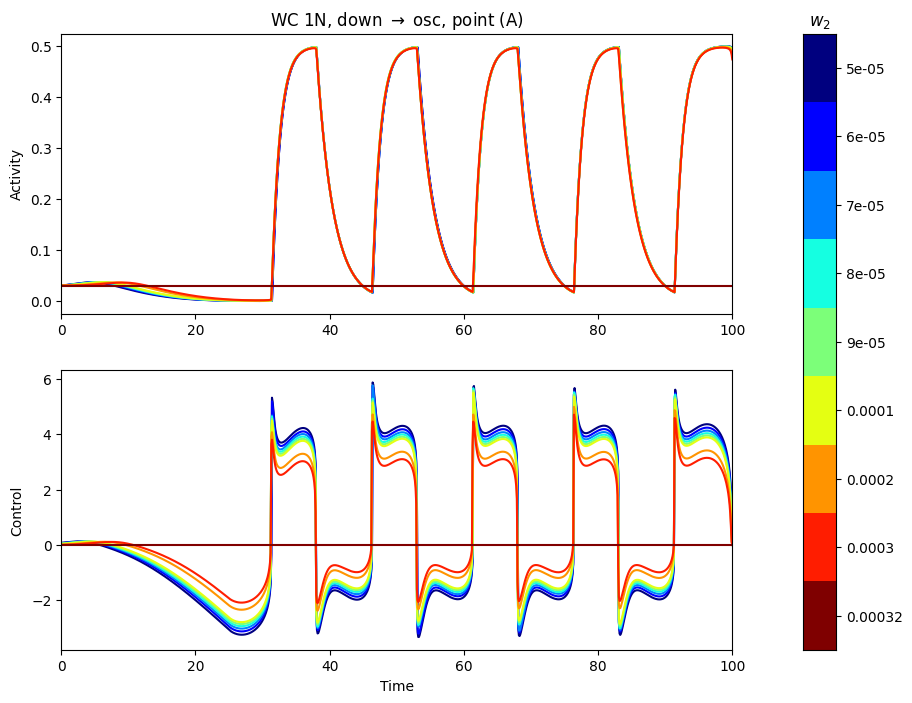

images_1n_wc_w1/B.png


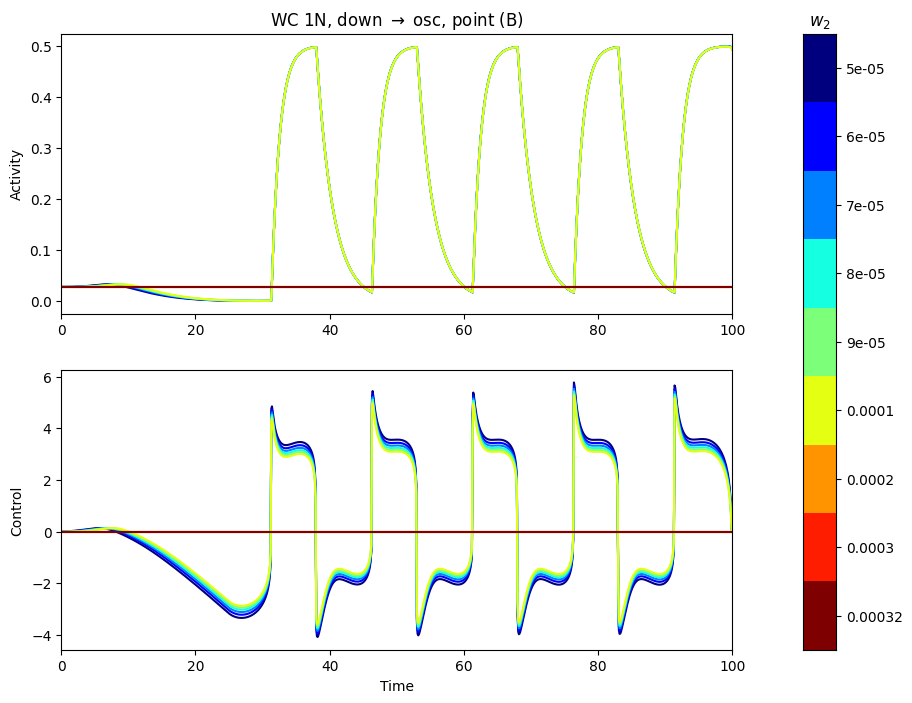

images_1n_wc_w1/C.png


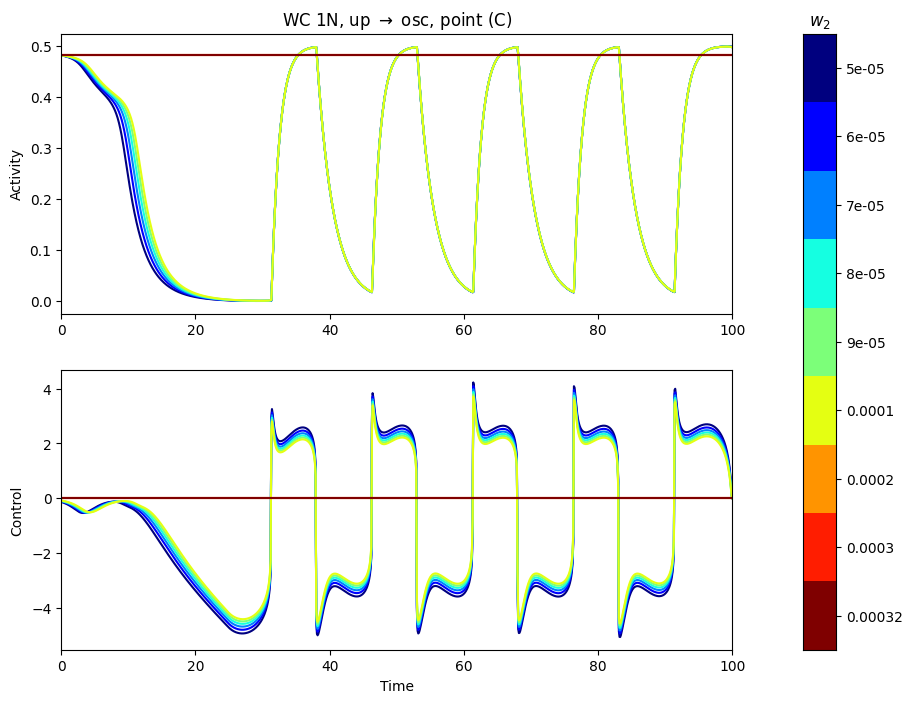

images_1n_wc_w1/D.png


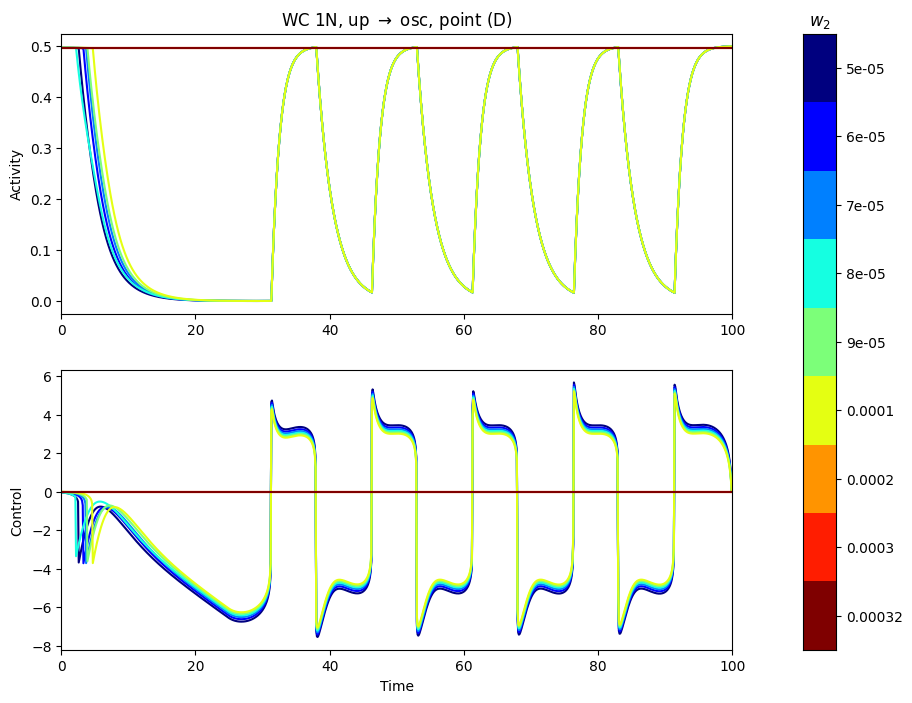

In [42]:
for i in range(len(p_names)):

    filename = os.path.join(dir, p_names[i] + ".png")
    print(filename)
    plot_w(data[p_names[i]], duration, dt, filename)

In [17]:
cmap = plt.cm.get_cmap("jet")

def plot_w(data, dur, dt, filename):
    fig, ax = plt.subplot_mosaic(   [['upper left', 'right'], ['lower left', 'right']],
                                    gridspec_kw={'width_ratios': [20,1]},
                                    figsize=(10,8))
    time_array = np.arange(0, dur+dt, dt)

    for iw in range(len(w1_array)):
        c = cmap(iw/(len(w1_array)-1))

        ax["upper left"].plot(time_array, data["state"][iw][0,0,:], color=c)
        ax["lower left"].plot(time_array, data["control"][iw][0,0,:], color=c)

    ax["upper left"].set_xlim(0, duration)
    ax["lower left"].set_xlim(0, duration)

    ax["lower left"].set_xlabel("Time")
    ax["upper left"].set_ylabel("Activity")
    ax["lower left"].set_ylabel("Control")

    grad = np.linspace(w1_array[0], w1_array[-1], len(w1_array))
    ax["right"].imshow(np.vstack((grad, grad)).T, aspect='auto', cmap=cmap)
    ax["right"].set_xticks([])
    ax["right"].set_yticks(np.arange(0,len(w1_array),1))
    ax["right"].set_yticklabels(np.around(w1_array,5))
    ax["right"].yaxis.tick_right()
    ax["right"].set_title(r"$w_2$")

    title = "WC 1N, "
    if "A" in filename or "B" in filename:
        title = title + r"down $\rightarrow$ osc, point $($"
    elif "C" in filename or "D" in filename:
        title = title + r"up $\rightarrow$ osc, point $($"

    title = title + filename[-5] + r")"

    ax["upper left"].set_title(title)
    fig.align_ylabels([ax["upper left"], ax["lower left"]])
    plt.savefig(filename)
    plt.show()
    return

def plot_w_zoom(data, dur, dt, filename):
    fig, ax = plt.subplots(2,2, figsize=(10,10), gridspec_kw={'width_ratios': [3, 2]}, sharex="col", sharey="row")
    time_array = np.arange(0, dur+dt, dt)

    for iw in range(len(w1_array)):
        c = cmap(iw/(len(w1_array)-1))

        ax[0, 0].plot(time_array, data["state"][iw][0,0,:], color=c, label=r"$w_2=$"+str(w1_array[iw]))
        ax[1, 0].plot(time_array, data["control"][iw][0,0,:], color=c)

        mins = scipy.signal.find_peaks(-data["state"][iw][0,0,:])[0]
        i0, i1 = mins[-3]-10, mins[-2]+10

        time_osc = np.linspace(0, (i1-i0)*dt, i1-i0, endpoint=True)
        #print(i1 - i0)

        ax[0, 1].plot(time_osc, data["state"][iw][0,0,i0:i1], color=c)
        ax[1, 1].plot(time_osc, data["control"][iw][0,0,i0:i1], color=c)

    ax[0,0].set_xlim(0, duration)
    ax[1,0].set_xlim(0, duration)
    ax[0,1].set_xlim(0, (i1-i0)*dt)
    ax[1,1].set_xlim(0, (i1-i0)*dt)

    ax[1,0].set_xlabel("Time")
    ax[1,1].set_xlabel("Time")
    ax[0,0].set_ylabel("Activity")
    ax[1,0].set_ylabel("Control")

    ax[0,0].legend(loc="upper left")

    fig.suptitle("Point " + filename[-5])

    plt.savefig(filename)

    plt.show()
    return

In [14]:
with open('osc_1n_wc_w1.pickle', 'wb') as f:
    pickle.dump(data, f)

In [5]:
with open('osc_1n_wc_w1.pickle', 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['A', 'B', 'C', 'D'])
